In [28]:
#Auotograd
import torch

In [29]:
x=torch.ones(2,2,requires_grad=True)
print(x)


tensor([[1., 1.],
        [1., 1.]], requires_grad=True)


In [30]:
y=x+2
print(y)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


In [31]:
#y是一次运算的结果，所以是有grad_fn的
print(y.grad_fn)

In [32]:
z=y*y*3
out=z.mean()
print(z,out)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(27., grad_fn=<MeanBackward0>)


In [33]:
a=torch.rand(2,2)
a=((a*3)/(a-1))
print(a.requires_grad)
a.requires_grad_(True)
print(a.requires_grad)
b=(a*a).sum()
print(b.grad_fn)


False
True


In [34]:
out.backward()
print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


In [35]:
x=torch.randn(3,requires_grad=True)
y=x*2
while y.data.norm()<1000:
    y=y*2
print(y)

tensor([ -365.9189,   810.9857, -1675.1530], grad_fn=<MulBackward0>)


In [36]:
v=torch.tensor([0.1,1.0,0.0001],dtype=torch.float)
y.backward(v)

print(x.grad)

tensor([1.0240e+02, 1.0240e+03, 1.0240e-01])


In [37]:
#卷积，填充
import torch
from torch import nn
#计算卷积层函数，对输入和输出进行升维，降维
def comp_conv2d(conv2d,X):
    X=X.view((1,1)+X.shape)#(1,1)代表批量大小和通道数
    Y=conv2d(X)
    return Y.view(Y.shape[2:])#不关心前两维，批量与通道
conv2d=nn.Conv2d(in_channels=1,out_channels=1,kernel_size=3,padding=1)#注意这个是在两侧分别填充一行/列，所以总共是填充了2，填出10x10
X=torch.rand(8,8)
comp_conv2d(conv2d,X).shape#10 10用3 3卷积，得到8 8

torch.Size([8, 8])

In [38]:
#当然宽和高不同也可以设置不同的填充数使输入输出有相同的宽和高
conv2d=nn.Conv2d(in_channels=1,out_channels=1,kernel_size=(5,3),padding=(2,1))#高为5宽为3的卷积核，填充是2，1
comp_conv2d(conv2d,X).shape


torch.Size([8, 8])

In [39]:
#设置步幅
conv2d=nn.Conv2d(1,1,kernel_size=3,padding=1,stride=2)
comp_conv2d(conv2d,X).shape

torch.Size([4, 4])

In [40]:
#尝试池化层
X=torch.arange(16,dtype=torch.float).view((1,1,4,4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [41]:
pool2d=nn.MaxPool2d(3)
pool2d(X)#默认步幅形状是(3,3)

tensor([[[[10.]]]])

In [42]:
pool2d=nn.MaxPool2d(3,padding=1,stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [43]:
#define the network
import torch.nn as nn
import torch.nn.functional as F
import torch
class Net(nn.Module):

    def __init__(self):
        super(Net,self).__init__()
        #一个输入通道，6个输出通道，3x3卷积核
        #kernel1
        self.conv1=nn.Conv2d(1,6,3)#对应的是输入，输出通道，核大小
        self.conv2=nn.Conv2d(6,16,3)
        #affine计算
        self.fc1=nn.Linear(16*6*6,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)
    def forward(self,x):
        #Max pooling over a (2,2) window
        x=F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x=F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        x=x.view(-1,self.num_flat_features(x))
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x
    def num_flat_features(self,x):
        size=x.size()[1:]#包含除了batchsize之外的维度
        num_features=1
        for s in size:
            num_features*=s
        return num_features
net=Net()
print(net)
#我们只需要定义前馈函数，反向传播函数会用自动求导求出

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [44]:
#可以洗参数可以由net.parameters()获取
params=list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 3, 3])


In [45]:
#尝试一下输入32x32.注意，这个网络是LeNet,输入大小要是32x32
input=torch.randn(1,1,32,32)
out=net(input)
print(out)

tensor([[-0.0590, -0.0758, -0.0413, -0.0877, -0.0515,  0.1274, -0.0164, -0.1189,
          0.1340,  0.0203]], grad_fn=<AddmmBackward>)


In [46]:
net.zero_grad()
out.backward(torch.randn(1,10))
#注意torch.nn只支持mini-batches的输入，比如nn.Conv2d会接收一个四维的张量，样本容量x通道数x高x宽。如果只有一个样本，使用input.unsqueeze(0)增加一个维度


In [47]:
#计算损失
output=net(input)
target=torch.randn(10)
target=target.view(1,-1)
criterion=nn.MSELoss()

loss=criterion(output,target)
print(loss)

tensor(0.4592, grad_fn=<MseLossBackward>)


In [48]:
print(loss.grad_fn)
print(loss.grad_fn.next_functions[0][0])
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])

In [49]:
#反向传播。我们要先清零梯度
net.zero_grad()

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([-0.0120,  0.0012,  0.0042, -0.0005,  0.0098, -0.0004])


In [50]:
#更新梯度
learning_rate=0.01
for f in net.parameters():
    f.data.sub_(f.grad.data*learning_rate)

In [51]:
#若想使用更多的梯度更新方法，我们可以使用torch.optim
import torch.optim as optim
import time
start=time.time()
optimizer=optim.SGD(net.parameters(),lr=0.01)

optimizer.zero_grad()#梯度置为零
output=net(input)
loss=criterion(output,target)
loss.backward()
optimizer.step()#进行更新

print(time.time()-start)

0.007978439331054688


In [52]:
#训练一个分类器
#数据从何而来？对于视觉，我们有一个包，torchversion,包含常见的数据集Imagenet,CIFAR10,MNIST.还有用于转换数据的转换器。torchvision.datasets and torch.utils.data.DataLoader
#这个教程将使用CIFAR10.含有飞机，手机，鸟，猫，鹿，狗，青蛙，房子，船，卡车。图片型号是3x32x32


#先加载并标准化
import torch
import torchvision
import torchvision.transforms as transforms


In [53]:
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])#把数个转换组合，ToTensor()是把PIL图片变为numpy,Normalize是把范围[0,1]变为[-1,1]
trainset=torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)

trainloader=torch.utils.data.DataLoader(trainset,batch_size=4,shuffle=True,num_workers=0)



#这种下载方式太慢，是手动下载的

Files already downloaded and verified


In [54]:
testset=torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
testloader=torch.utils.data.DataLoader(testset,batch_size=4,shuffle=False,num_workers=0)

classes= ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


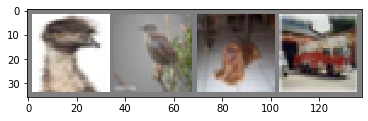

bird  bird   dog truck


In [56]:
#查看一些图片
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img=img/2+0.5#把数据还原
    npimg=img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))#关于transpose函数，默认情况下就是求转置，输入参数，一个表示坐标轴序列的tuple.比如原本为通道数x高x宽，维度编号为0 1 2，这里就换成了高x宽x通道
    plt.show()

dataiter=iter(trainloader)
images,labels=dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s'%classes[labels[j]] for j in range(4)))

In [71]:
#定义卷积神经网络，就把之前写的改为三通道
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [72]:
#定义损失函数和优化器
import torch.optim as optim

criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(net.parameters(),lr=0.001,momentum=0.9)

In [73]:
#训练
import time
start=time.time()
for epoch in range(2):

    running_loss=0.0
    for i,data in enumerate(trainloader,0):
        inputs,labels=data

        optimizer.zero_grad()

        outputs=net(inputs)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        running_loss+=loss.item()
        if i%2000==1999:#每2000个batch打印一次
            print('[%d,%5d] loss:%.3f'%(epoch+1,i+1,running_loss/2000))
            running_loss=0.0
print('Finished Training')
print(time.time()-start)

[1, 2000] loss:2.236
[1, 4000] loss:1.925
[1, 6000] loss:1.725
[1, 8000] loss:1.617
[1,10000] loss:1.548
[1,12000] loss:1.492
[2, 2000] loss:1.426
[2, 4000] loss:1.367
[2, 6000] loss:1.358
[2, 8000] loss:1.331
[2,10000] loss:1.314
[2,12000] loss:1.289
Finished Training
167.88216376304626


In [60]:
#保存训练的模型
PATH='./cifar_net.pth'
torch.save(net.state_dict(),PATH)

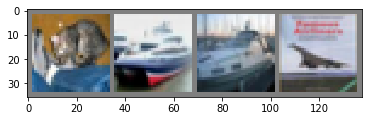

GroundTruth:   cat  ship  ship plane


In [61]:
#测试数据
dataiter=iter(testloader)
images,labels=dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth:',' '.join('%5s'%classes[labels[j]] for j in range(4)))

In [62]:
#加载保存的数据
net=Net()
net.load_state_dict(torch.load(PATH))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [63]:
outputs=net(images)

In [64]:
_,predicted=torch.max(outputs,1)
print('Predicted:',' '.join('%5s'%classes[predicted[j]] for j in range(4)))

Predicted:   cat  ship  ship  ship


In [65]:
#下面看看整体结果
correct=0
total=0
with torch.no_grad():
    for data in testloader:
        images,labels=data
        outputs=net(images)
        _,predicted=torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))   

Accuracy of the network on the 10000 test images: 56 %


In [66]:
#各类别的效果
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 61 %
Accuracy of   car : 77 %
Accuracy of  bird : 29 %
Accuracy of   cat : 35 %
Accuracy of  deer : 51 %
Accuracy of   dog : 49 %
Accuracy of  frog : 77 %
Accuracy of horse : 49 %
Accuracy of  ship : 67 %
Accuracy of truck : 61 %


In [79]:
#尝试GPU训练
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [80]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [81]:
#定义损失函数和优化器
import torch.optim as optim

criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(net.parameters(),lr=0.001,momentum=0.9)


In [82]:
#训练
import time
start=time.time()
for epoch in range(2):

    running_loss=0.0
    for i,data in enumerate(trainloader,0):
        inputs,labels=data[0].to(device),data[1].to(device)

        optimizer.zero_grad()

        outputs=net(inputs)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        running_loss+=loss.item()
        if i%2000==1999:#每2000个batch打印一次
            print('[%d,%5d] loss:%.3f'%(epoch+1,i+1,running_loss/2000))
            running_loss=0.0
print('Finished Training')
print(time.time()-start)

[1, 2000] loss:1.240
[1, 4000] loss:1.239
[1, 6000] loss:1.209
[1, 8000] loss:1.205
[1,10000] loss:1.202
[1,12000] loss:1.178
[2, 2000] loss:1.112
[2, 4000] loss:1.131
[2, 6000] loss:1.114
[2, 8000] loss:1.125
[2,10000] loss:1.123
[2,12000] loss:1.117
Finished Training
180.3126997947693
